# Test models performences

2025-06-03 23:59:22.333279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748984362.401024  136323 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748984362.420425  136323 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748984362.573408  136323 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748984362.573437  136323 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748984362.573440  136323 computation_placer.cc:177] computation placer alr

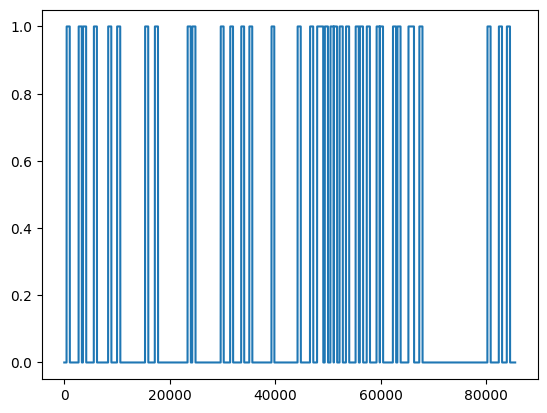

: 

In [ ]:
# import modules and load data
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

import glob
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load input and output data
X = np.load("../data/processed/input.npy")
Y = np.load("../data/processed/output.npy")

# TODO: Custom shuffle for RNN model
x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(X, Y, test_size=0.2, shuffle=False)
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x_train_s, y_train_s, test_size=0.25, shuffle=False)

# 60% train data
# 20% validation data
# 20% test data

plt.plot(range(len(y_val_s)), y_val_s)
plt.show()

#### Model 1

In [ ]:
from model import create_sequences

# Number of frames fed into the LSTM layer at one time
sequence_length = 20*30

# FIX IT
# Reshape the data from (n, 14) to (n, sequence_length, 14)
x_train, y_train = create_sequences(x_train_s, y_train_s, sequence_length)
x_val, y_val = create_sequences(x_val_s, y_val_s, sequence_length)
x_test, y_test = create_sequences(x_test_s, y_test_s, sequence_length)

# Adapt the normlizer layer to the feature axis in the input data
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(x_train)

# Define the model 
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(sequence_length,14)),
    normalizer,
    # layers.SimpleRNN(1024, input_shape=(1,14) ,return_sequences=False),  # or use LSTM/GRU
    layers.LSTM(512, input_shape=(sequence_length,14), recurrent_dropout=0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')  # Output a single scalar
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model (20 epochs atleast)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=64)


## Test Performences

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings

warnings.filterwarnings('ignore')

# Model 1
print("==== MODEL #1 ====")

# Predict probabilities
y1_prob = model.predict(x_test)

# Convert probabilities to binary predictions (> 50% for positive prediction)
y1_pred = (y1_prob >= 0.5).astype(int).squeeze() 

# Confusion Matrix
cm1 = confusion_matrix(y_test, y1_pred)
disp1 = ConfusionMatrixDisplay(cm1)

print("Probability Plot:")
plt.plot(range(len(y1_prob)), y1_prob)
plt.show()

print("Predition/Test Plot:")
plt.plot(range(len(y1_pred)), y1_pred, y_test)
plt.show()

# Classification Report
report1 = classification_report(y_test, y1_pred)

disp1.plot()
print("Classification Report:\n", report1)
